In [1]:
#Let's start with simple linear regression
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ex = pd.read_table('GPA_copy.txt',sep='\s+')

In [4]:
#This dataset contains 20 observations of two values. We will try to predict a students college GPA from a score 
#on a test that they take before entering college.
ex.head()

,GPA,Score
0,3.1,5.5
1,2.3,4.8
2,3.0,4.7
3,1.9,3.9
4,2.5,4.5


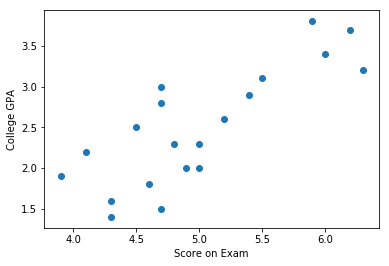

In [5]:
#Let's observe the data in a scatter plot before we begin
plt.scatter(ex.Score,ex.GPA)
plt.xlabel('Score on Exam')
plt.ylabel('College GPA')
plt.show()

In [6]:
#import the linear regression from sklearn
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [7]:
#Investigate the shape of the data and reshape so that sklearn can use it properly
X = ex.Score
y = ex.GPA
print X.shape, y.shape

X = np.reshape(X,(20,1))
y = np.reshape(y,(20,1))

(20,) (20,)


/Users/cshartrand/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


In [8]:
#Fit the regression model and print the intercept and regression coefficient
lm.fit(X,y)
print lm.intercept_, lm.coef_

[-1.6995614] [[ 0.83991228]]


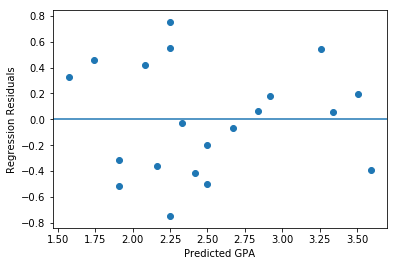

In [9]:
#Check out the residuals versus fitted values plot
pred = lm.predict(X)
res = y - pred
plt.scatter(pred,res)
plt.xlabel('Predicted GPA')
plt.ylabel('Regression Residuals')
plt.axhline(y=0)
plt.show()

In [70]:
#Regression Diagnostics with Multiple Linear Regression
gala = pd.read_csv('galapagos.csv', index_col=0)
print gala.head()

#We would like to predict the number of species on each island based on corresponding information about that island
X = gala.drop(['Species','Endemics'],axis=1)
y = gala['Species']

lm.fit(X,y)

           Species  Endemics   Area  Elevation  Nearest  Scruz  Adjacent
Baltra          58        23  25.09        346      0.6    0.6      1.84
Bartolome       31        21   1.24        109      0.6   26.3    572.33
Caldwell         3         3   0.21        114      2.8   58.7      0.78
Champion        25         9   0.10         46      1.9   47.4      0.18
Coamano          2         1   0.05         77      1.9    1.9    903.82


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [71]:
#Now lets find predicted values, residuals and standardized residuals

pred = lm.predict(X)
res = y - pred

Xmat = X.as_matrix()
nobs = Xmat.shape[0]
m = Xmat.shape[1]
ones = np.ones((nobs,1))
Xmat = np.hstack([ones,Xmat])

from numpy.linalg import inv
H = np.dot(np.dot(Xmat,inv(np.dot(Xmat.T,Xmat))),Xmat.T)

RSE = np.sqrt(np.sum(res**2)/(nobs-m-1))

std_res = res/(RSE*np.sqrt(1-np.diag(H)))

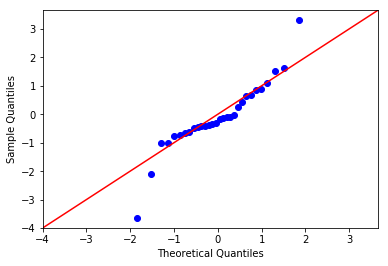

In [12]:
#And lets make a QQPlot
import statsmodels.api as sm
sm.qqplot(std_res,line='45')
plt.show()

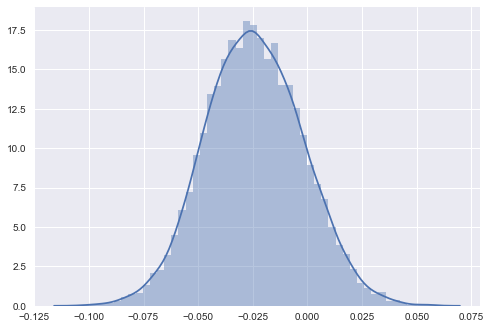

In [13]:
#Bootstrapping
#Let's do some simulations
beta = np.append(lm.intercept_,lm.coef_)
XTinv = inv(np.dot(Xmat.T,Xmat))

#Simulate some betas
nrows = 10000
ncols = 6
beta_sim = np.zeros((nrows,ncols))

for i in range(0,nrows):
    y_sim = np.dot(Xmat,beta) + np.random.normal(0,RSE,nobs)
    beta_sim[i,] = np.dot(np.dot(XTinv,Xmat.T),y_sim)

#Plot the density distribution for the coefficient of Area
import seaborn as sns
sns.distplot(beta_sim[:,1]);
#Here we can see the mean of the simulations seems to be slightly less than zero, as we would expect.

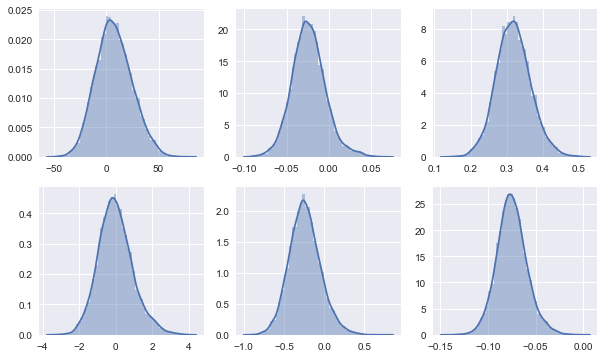

In [14]:
#Now for the actual bootstrapping part
beta_boot = np.zeros((nrows,ncols))
for i in range(0,nrows):
    error = np.random.choice(res,size = nobs, replace=True)
    y_boot = np.dot(Xmat,beta) + error
    beta_boot[i,] = np.dot(np.dot(XTinv,Xmat.T),y_boot)
#And some plots
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(10,6))
sns.distplot(beta_boot[:,0],ax=axes[0,0])
sns.distplot(beta_boot[:,1],ax=axes[0,1])
sns.distplot(beta_boot[:,2],ax=axes[0,2])
sns.distplot(beta_boot[:,3],ax=axes[1,0])
sns.distplot(beta_boot[:,4],ax=axes[1,1])
sns.distplot(beta_boot[:,5],ax=axes[1,2]);

In [15]:
#Finally lets find the condfidence intervals of these bootstraps
con_boot = np.zeros((6,2))
for i in range(0,6):
    con_boot[i,] = np.percentile(beta_boot[:,i],[2.5,97.5])
print con_boot

[[ -2.39854443e+01   4.27696223e+01]
 [ -6.10829845e-02   2.02307181e-02]
 [  2.27549566e-01   4.18843860e-01]
 [ -1.72354590e+00   2.09018300e+00]
 [ -6.02600325e-01   1.67311755e-01]
 [ -1.04733172e-01  -4.10250702e-02]]


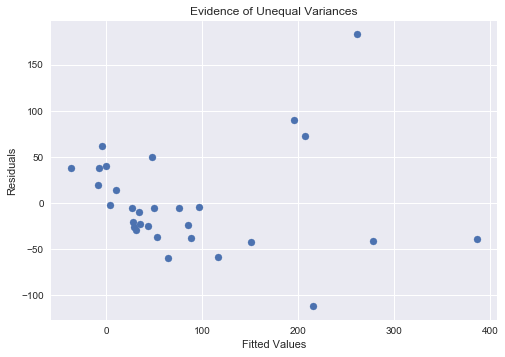

In [16]:
#Invetigate Unequal Variances
plt.scatter(pred,res)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Evidence of Unequal Variances')
plt.show()
#This 'fanning' out of the residuals indicates some heteroscedasticity in the data.
#We should consider a transformation somewhere in our analysis.

In [17]:
#Log transformation
predictors = ['Area','Elevation','Nearest','Scruz','Adjacent']
response = ['Species']
lm.fit(gala[predictors],np.log(gala[response]))
print lm.intercept_, lm.coef_

[ 2.30743186] [[-0.00073527  0.00450201  0.01656664 -0.00389692 -0.0008001 ]]


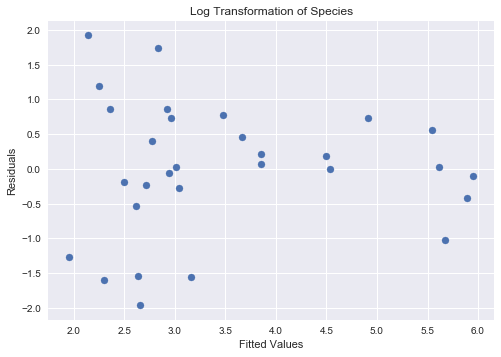

In [33]:
#Recalculate fitted and residuals based on the new model
log_pred = lm.predict(gala[predictors])
log_res = np.log(gala[response]) - log_pred
#And plot them
plt.scatter(log_pred,log_res)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Log Transformation of Species')
plt.show()
#Notice the difference?

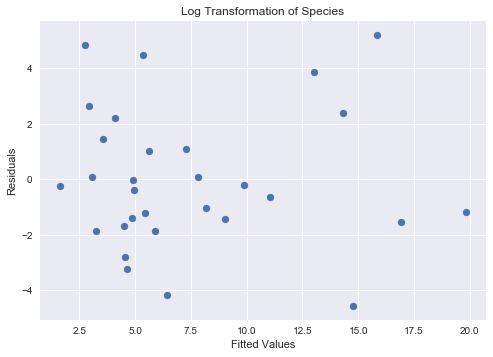

In [18]:
#Let's do a square root transformation for good measure
lm.fit(gala[predictors],np.sqrt(gala[response]))
sq_pred = lm.predict(gala[predictors])
sq_res = np.sqrt(gala[response]) - sq_pred

plt.scatter(sq_pred,sq_res)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Log Transformation of Species')
plt.show()

In [19]:
#Has the model improved based on R^2?
lm.fit(gala[predictors],gala[response])
r2 = lm.score(gala[predictors],gala[response])

lm.fit(gala[predictors],np.log(gala[response]))
r2log = lm.score(gala[predictors],np.log(gala[response]))

lm.fit(gala[predictors],np.sqrt(gala[response]))
r2sq = lm.score(gala[predictors],np.sqrt(gala[response]))

print r2, r2log, r2sq
#It seems so

0.765846944681 0.624922333461 0.782697660626


In [20]:
#Correlated Errors and Generalized Least Squares
globwarm = pd.read_csv('globwarm.csv',index_col=0)
globwarm.head()
#This is a dataset on global warming from the Faraway library in R. See documentation for more details

,nhtemp,wusa,jasper,westgreen,chesapeake,tornetrask,urals,mongolia,tasman,year
1000,NaN,-0.66,-0.03,0.03,-0.66,0.33,-1.49,0.83,-0.12,1000
1001,NaN,-0.63,-0.07,0.09,-0.67,0.21,-1.44,0.96,-0.17,1001
1002,NaN,-0.60,-0.11,0.18,-0.67,0.13,-1.39,0.99,-0.22,1002
1003,NaN,-0.55,-0.14,0.30,-0.68,0.08,-1.34,0.95,-0.26,1003
1004,NaN,-0.51,-0.15,0.41,-0.68,0.06,-1.30,0.87,-0.31,1004


In [21]:
#There are a lot of missing temperature values. Let's get rid of the NA values
globwarm2 = globwarm.dropna(axis=0,how='any')
globwarm2.head()

,nhtemp,wusa,jasper,westgreen,chesapeake,tornetrask,urals,mongolia,tasman,year
1856,-0.37,-0.78,-0.15,-0.06,0.80,0.41,-0.05,-1.27,0.10,1856
1857,-0.35,-0.81,-0.15,-0.24,0.70,0.46,-0.06,-1.18,0.25,1857
1858,-0.33,-0.84,-0.15,-0.41,0.58,0.49,-0.08,-1.07,0.40,1858
1859,-0.09,-0.85,-0.15,-0.57,0.44,0.49,-0.09,-0.98,0.52,1859
1860,-0.37,-0.84,-0.16,-0.70,0.32,0.45,-0.11,-0.90,0.61,1860


In [22]:
#We will want to fit the GLS with an AR1 correlation matrix. There are a few steps needed to do this
predictors = ['wusa','jasper','westgreen','chesapeake','tornetrask','urals','mongolia','tasman']
response = ['nhtemp']

X = sm.add_constant(globwarm2[predictors])

#We need to fit an OLS model and get the residuals for that

ols_resid = sm.OLS(globwarm2[response],X).fit().resid

In [23]:
#Now fit a model to the residuals where we predict the next year's residual based on the previous year
#Reformat to work
ols_resid = ols_resid.as_matrix()
resid_fit = sm.OLS(ols_resid[1:], sm.add_constant(ols_resid[:-1])).fit()

print (resid_fit.pvalues[1]) #strong evidence of an AR(1) relationship. We will use this for correlation matrix

1.68957012584e-14


In [24]:
#Create the correlation matrix where adjacent years will be most heavily weighted
rho = resid_fit.params[1]
from scipy.linalg import toeplitz
order = toeplitz(range(len(ols_resid)))
sigma = rho**order #produces a matrix with decreasing correlation as the years diverge

In [25]:
#Now fit the model
gls_model = sm.GLS(globwarm2[response], sm.add_constant(globwarm2[predictors]), sigma=sigma)
gls_results = gls_model.fit()
print gls_results.summary()

                            GLS Regression Results                            
Dep. Variable:                 nhtemp   R-squared:                       0.181
Model:                            GLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     3.764
Date:                Mon, 17 Apr 2017   Prob (F-statistic):           0.000517
Time:                        10:52:15   Log-Likelihood:                 81.106
No. Observations:                 145   AIC:                            -144.2
Df Residuals:                     136   BIC:                            -117.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.2338      0.050     -4.646      0.0

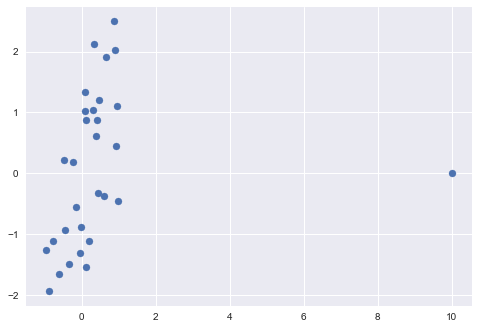

In [120]:
#Outlier Analysis to come....
#Generate some data
x = np.random.uniform(-1,1,30)
x[29] = 10 #input a large outlier in both x
y = x + np.random.normal(0,1,30)
y[29] = 0 #....and y
plt.scatter(x,y)

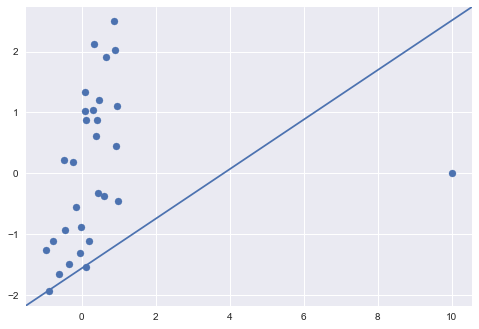

In [121]:
#now fit a regression and draw the abline to see how bad the fit is
x = np.reshape(x,(30,1))
y = np.reshape(y,(30,1))
lm.fit(x,y)
def abline():
    gca = plt.gca()
    gca.set_autoscale_on(False)
    gca.plot(gca.get_xlim(),gca.get_ylim())

plt.scatter(x,y)
abline()
plt.draw()
#what other metrix can we use to identify these outliers, influential points, etc.

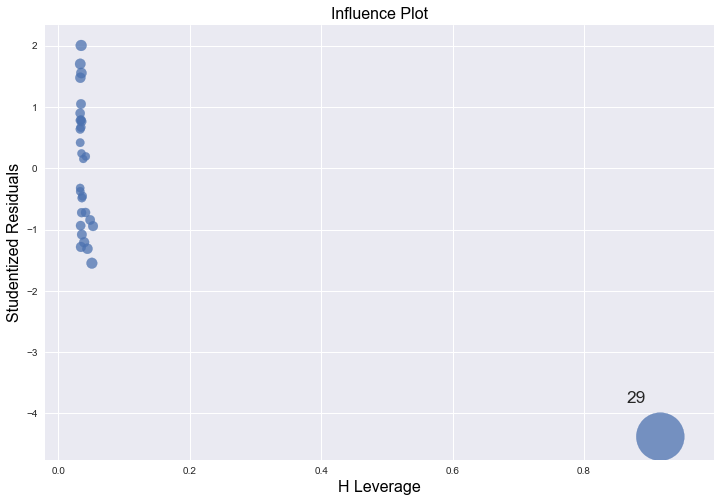

In [139]:
#Cook's Distance
out_model = sm.OLS(y, sm.add_constant(x))
out_results = out_model.fit()
influence= out_results.get_influence()

(c,p) = influence.cooks_distance #produce the cooks distance

#plot the results
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(out_results, ax=ax, criterion="cooks")


In [244]:
#Half normal residual plot
lm.fit(x,y)
pred = lm.predict(x)
res = y - pred

nobs = Xmat.shape[0]
m = Xmat.shape[1]
ones = np.ones((nobs,1))
Xmat = np.hstack([ones,x])

from numpy.linalg import inv
H = np.dot(np.dot(Xmat,inv(np.dot(Xmat.T,Xmat))),Xmat.T)

RSE = np.sqrt(np.sum(res**2)/(nobs-m-1))

denom = RSE*np.sqrt(1-np.diag(H))

std_res = np.zeros(30)
for i in range(0,30):
    std_res[i] = res[i]/denom[i]
abs_res = np.absolute(std_res)
hold_outlier = []
hold_i = []
for i in range(0,30):
    if abs_res[i] >= 2.0:
        hold_outlier.append(abs_res[i])
        hold_i.append(i)
    
abs_res.sort()

In [245]:
from scipy.stats import norm
invnorm = np.zeros(30)
for i in range(1,30):
    invnorm[i] = norm.ppf((i+30+.5)/(2*30.+9./8))


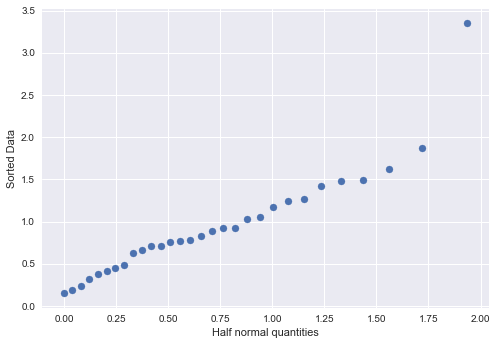

In [246]:
plt.scatter(invnorm,abs_res)
plt.xlabel('Half normal quantities')
plt.ylabel('Sorted Data')
plt.show();